# Elementary Cellular Automata Classification
## Feature Extraction Pipeline for GNN-based Classification

**Research Objective**: Develop a comprehensive feature extraction framework for classifying Elementary Cellular Automata (ECA) using Graph Neural Networks

**Presentation Date**: 16/10/2025

## 1. Introduction and Theoretical Background

### 1.1 Elementary Cellular Automata (ECA)

Elementary Cellular Automata are one-dimensional discrete dynamical systems consisting of:
- **State space**: Binary states {0, 1}
- **Neighborhood**: 3-cell neighborhoods (left, center, right)
- **Update rule**: $f: \{0,1\}^3 \rightarrow \{0,1\}$

Each of the 256 possible rules can be uniquely identified by its Wolfram number, derived from the binary representation of its truth table.

### 1.2 Wolfram's Classification

Wolfram proposed four behavioral classes:
- **Class I**: Evolution to homogeneous state
- **Class II**: Evolution to simple periodic structures
- **Class III**: Chaotic, aperiodic behavior
- **Class IV**: Complex structures, long transients

### 1.3 Feature Extraction Approaches

I implement 6 complementary feature extraction methods:
1. **Mean-field parameters** (rule-based)
2. **μ-sensitivity** (rule-based)
3. **Compression ratio** (dynamics-based)
4. **Spectral analysis** (dynamics-based)
5. **Difference spreading** (dynamics-based)
6. **Rényi entropy** (dynamics-based)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gzip
import pandas as pd
from scipy import signal
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Environment setup complete!")

Environment setup complete!


## 2. Definition and Function of ECA 

### 2.1 Core ECA Functions

In [ ]:
# Cellular Automaton Functions
def rule_to_binary(rule_number):
    """
    Convert rule number to 8-bit binary representation.
    
    Args:
        rule_number (int): Wolfram rule number (0-255)
    
    Returns:
        str: 8-bit binary string
    """
    return format(rule_number, '08b')


def evolve_eca(rule_number, initial_config, steps):
    """
    Evolve ECA according to specified rule.
    
    The evolution follows the update rule:
    new_state[i] = f(state[i-1], state[i], state[i+1])
    
    Args:
        rule_number (int): Wolfram rule number (0-255)
        initial_config (np.array): Initial configuration of cells
        steps (int): Number of time steps to evolve
    
    Returns:
        np.array: Spacetime matrix of shape (steps+1, N)
    """
    rule_binary = rule_to_binary(rule_number)
    N = len(initial_config)
    spacetime = np.zeros((steps + 1, N), dtype=np.uint8)
    spacetime[0] = initial_config
    
    for t in range(steps):
        current = spacetime[t]
        next_state = np.zeros(N, dtype=np.uint8)
        
        for i in range(N):
            # Periodic boundary conditions
            left = current[(i-1) % N]
            center = current[i]
            right = current[(i+1) % N]
            
            # Compute neighborhood index
            neighborhood = (left << 2) | (center << 1) | right
            next_state[i] = int(rule_binary[7 - neighborhood])
        
        spacetime[t+1] = next_state
    
    return spacetime


def plot_spacetime(spacetime, rule_number, title_suffix=""):
    """Visualize spacetime evolution of ECA."""
    plt.figure(figsize=(10, 6))
    plt.imshow(spacetime, cmap='binary', interpolation='nearest', aspect='auto')
    plt.title(f'Rule {rule_number} {title_suffix}', fontsize=14, fontweight='bold')
    plt.xlabel('Cell Position')
    plt.ylabel('Time Step')
    plt.colorbar(label='State')
    plt.tight_layout()
    plt.show()

### 2.2 Demonstration of ECA Evolution

Let's visualize the evolution of representative rules from each Wolfram class:

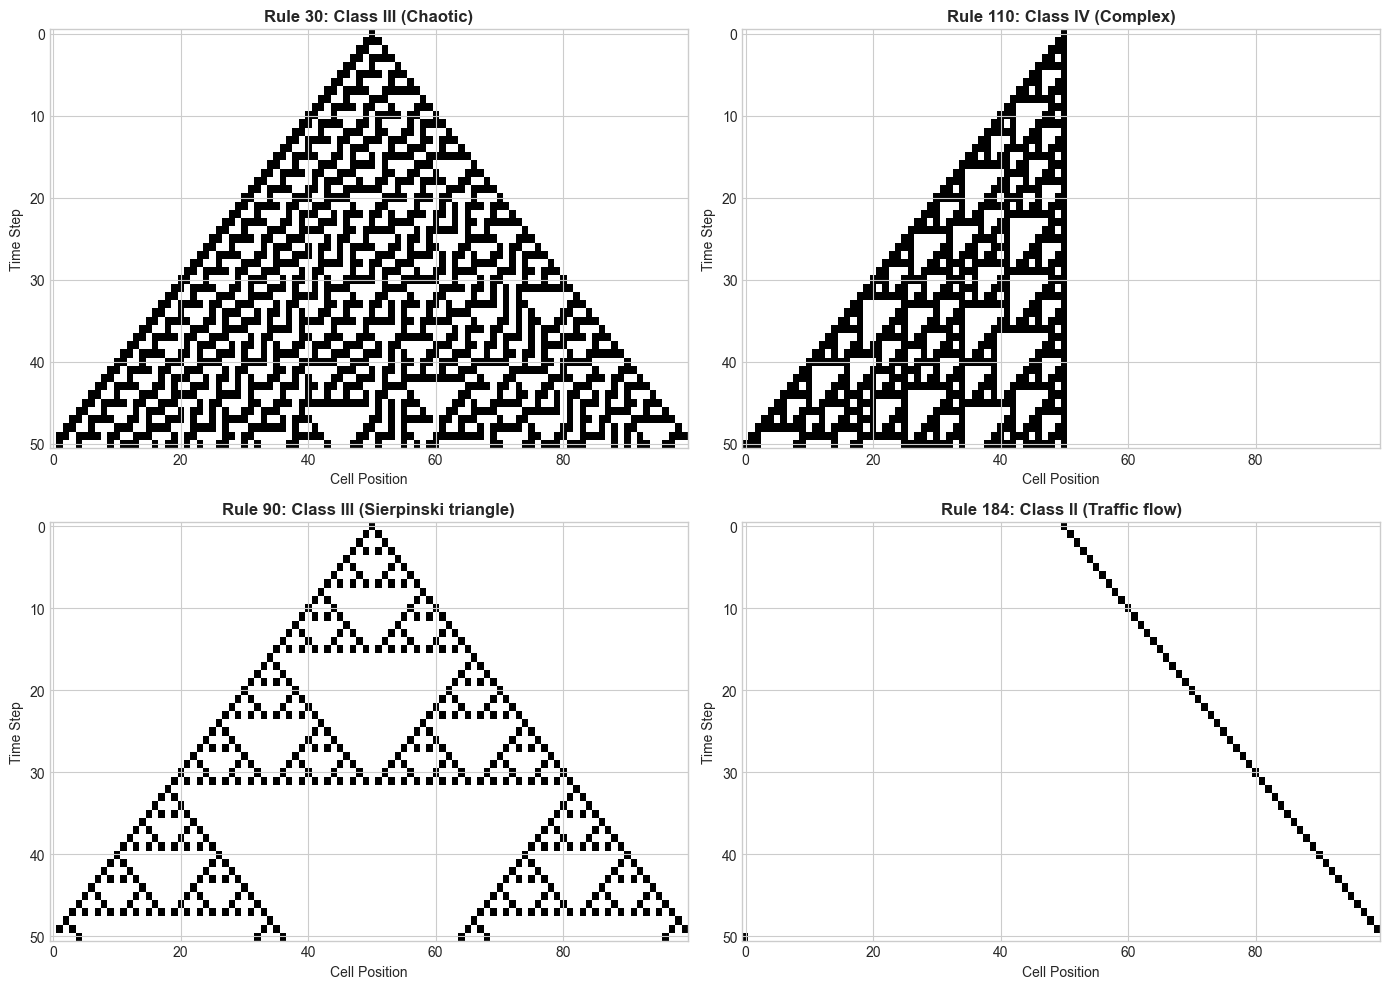

Basic ECA functionality verified!


In [34]:
# Create single-cell seed configuration
N_demo = 100
test_config = np.zeros(N_demo, dtype=np.uint8)
test_config[N_demo // 2] = 1  # Central seed

# Representative rules from each class
representative_rules = {
    30: "Class III (Chaotic)",
    110: "Class IV (Complex)",
    90: "Class III (Sierpinski triangle)",
    184: "Class II (Traffic flow)"
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (rule, description) in enumerate(representative_rules.items()):
    spacetime = evolve_eca(rule, test_config, 50)
    ax = axes[idx]
    im = ax.imshow(spacetime, cmap='binary', interpolation='nearest', aspect='auto')
    ax.set_title(f'Rule {rule}: {description}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cell Position')
    ax.set_ylabel('Time Step')

plt.tight_layout()
plt.show()

print("Basic ECA functionality verified!")

## 3. Rule-based Feature Extraction

These features are computed directly from the rule table without requiring evolution.

### 3.1 Mean-field Parameters

**Theory**: Mean-field parameters quantify the expected density change under the rule.

For a rule $f$, we define:
$$M_k = |\{s \in \{0,1\}^3 : |s|=k \text{ and } f(s)=1\}|$$

where $|s|$ denotes the number of 1s in neighborhood $s$.

**Langton's λ parameter**:
$$\lambda = \frac{\sum_{k=0}^{3} M_k}{8}$$

This measures the fraction of neighborhood configurations that map to state 1.


In [ ]:
def compute_mean_field_parameters(rule_number):
    """
    Compute mean-field parameters M0, M1, M2, M3.
    
    Mi represents the number of neighborhoods with i ones that map to 1.
    
    Args:
        rule_number (int): ECA rule number
    
    Returns:
        list: [M0, M1, M2, M3]
    """
    rule_binary = rule_to_binary(rule_number)
    M = [0, 0, 0, 0]
    
    for neighborhood in range(8):
        num_ones = bin(neighborhood).count('1')
        output = int(rule_binary[7 - neighborhood])
        
        if output == 1:
            M[num_ones] += 1
    
    return M


# Compute mean-field parameters for all 256 rules
print("Computing mean-field parameters for all ECA rules...")
mean_field_features = []

for rule in tqdm(range(256), desc="Mean-field analysis"):
    M = compute_mean_field_parameters(rule)
    mean_field_features.append([rule] + M)

mean_field_df = pd.DataFrame(mean_field_features, 
                              columns=['rule', 'M0', 'M1', 'M2', 'M3'])

# Calculate Langton's lambda
mean_field_df['lambda'] = (mean_field_df['M0'] + mean_field_df['M1'] + 
                            mean_field_df['M2'] + mean_field_df['M3']) / 8

print("\nSample results (first 10 rules):")
print(mean_field_df.head(10))

Computing mean-field parameters for all ECA rules...


Mean-field analysis: 100%|██████████| 256/256 [00:00<00:00, 379280.05it/s]


Sample results (first 10 rules):
   rule  M0  M1  M2  M3  lambda
0     0   0   0   0   0   0.000
1     1   1   0   0   0   0.125
2     2   0   1   0   0   0.125
3     3   1   1   0   0   0.250
4     4   0   1   0   0   0.125
5     5   1   1   0   0   0.250
6     6   0   2   0   0   0.250
7     7   1   2   0   0   0.375
8     8   0   0   1   0   0.125
9     9   1   0   1   0   0.250


### 3.1.1 Visualization of Mean-field Parameters

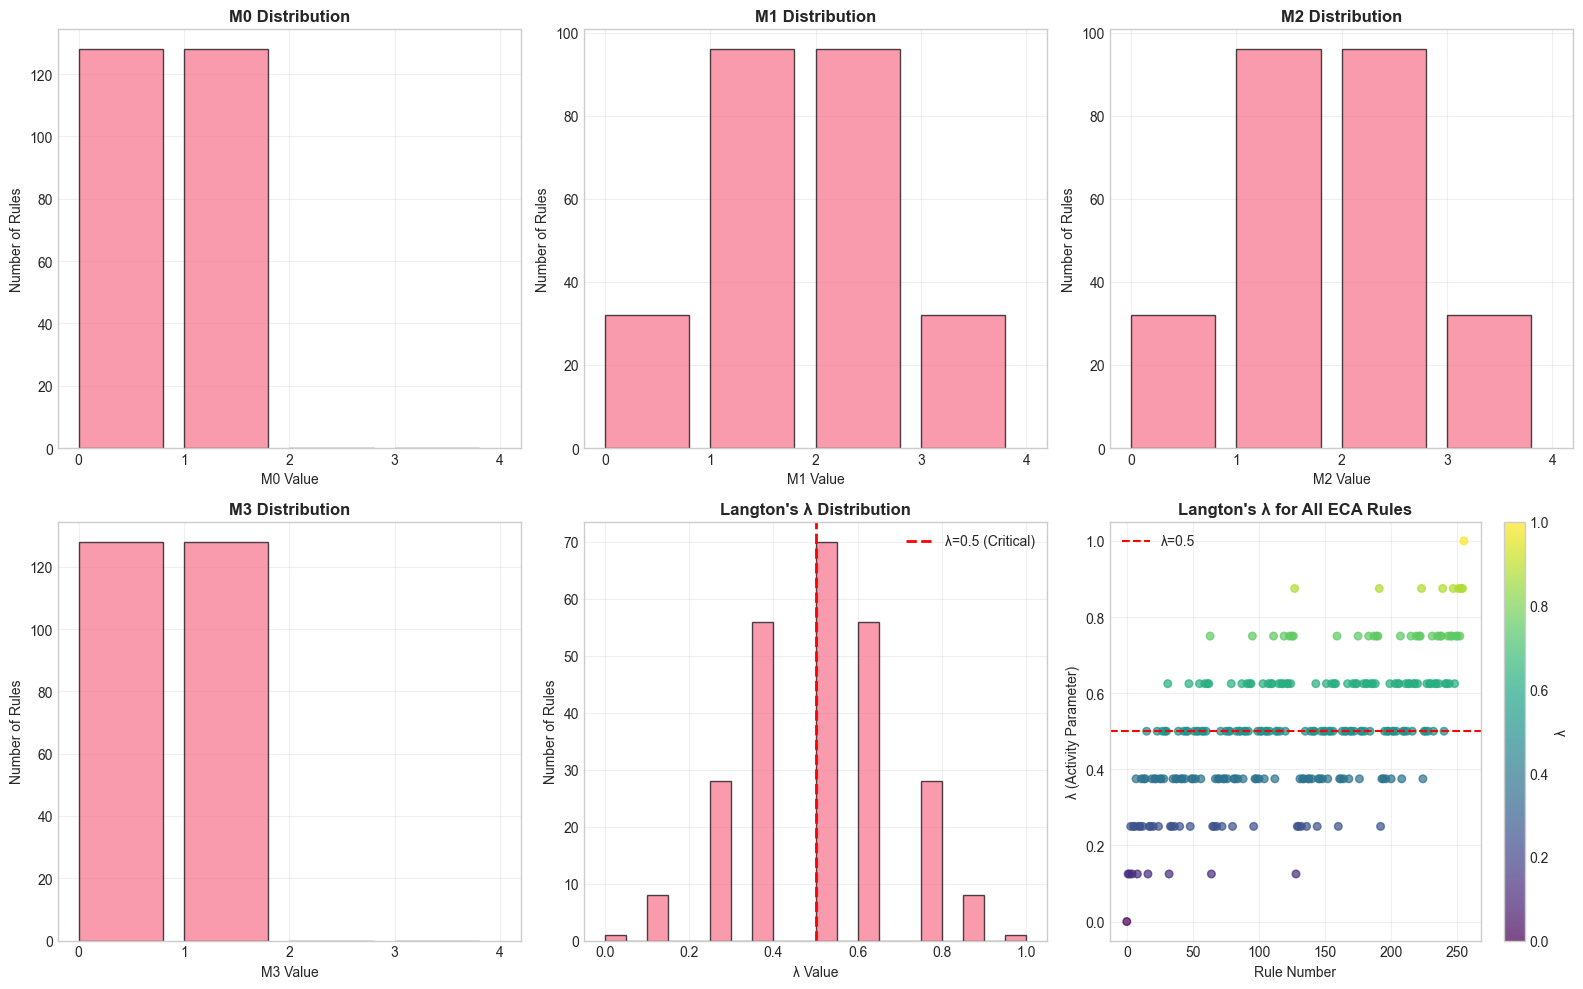

In [5]:
# Visualize mean-field parameter distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Plot Mi distributions
for idx, Mi in enumerate(['M0', 'M1', 'M2', 'M3']):
    ax = axes[idx]
    ax.hist(mean_field_df[Mi], bins=range(0, 5), alpha=0.7, edgecolor='black', width=0.8)
    ax.set_title(f'{Mi} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'{Mi} Value')
    ax.set_ylabel('Number of Rules')
    ax.set_xticks(range(5))
    ax.grid(alpha=0.3)

# Plot lambda distribution
ax = axes[4]
ax.hist(mean_field_df['lambda'], bins=20, alpha=0.7, edgecolor='black')
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='λ=0.5 (Critical)')
ax.set_title('Langton\'s λ Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('λ Value')
ax.set_ylabel('Number of Rules')
ax.legend()
ax.grid(alpha=0.3)

# Lambda vs Rule number
ax = axes[5]
scatter = ax.scatter(mean_field_df['rule'], mean_field_df['lambda'], 
                     c=mean_field_df['lambda'], cmap='viridis', s=30, alpha=0.7)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='λ=0.5')
ax.set_title('Langton\'s λ for All ECA Rules', fontsize=12, fontweight='bold')
ax.set_xlabel('Rule Number')
ax.set_ylabel('λ (Activity Parameter)')
ax.legend()
ax.grid(alpha=0.3)

plt.colorbar(scatter, ax=ax, label='λ')
plt.tight_layout()
plt.show()

### 3.2 μ-Sensitivity

**Theory**: The μ-sensitivity measures how sensitive a rule is to perturbations in its input.

For a Boolean function $f: \{0,1\}^n \rightarrow \{0,1\}$, the sensitivity at input $x$ is:
$$s(x) = |\{i : f(x) \neq f(x^{(i)})\}|$$

where $x^{(i)}$ denotes $x$ with bit $i$ flipped.

The average sensitivity (μ) is:
$$\mu = \frac{1}{2^n} \sum_{x \in \{0,1\}^n} s(x) = \frac{1}{2^n \cdot n} \sum_{x} \sum_{i} |f(x) - f(x^{(i)})|$$

For ECA with $n=3$:
$$\mu = \frac{1}{24} \sum_{x \in \{0,1\}^3} \sum_{i=1}^{3} |f(x) - f(x^{(i)})|$$


In [6]:
def compute_mu_sensitivity(rule_number):
    """
    Compute μ-sensitivity (average Boolean derivative).
    
    This measures the average sensitivity of the rule to single-bit perturbations
    in the neighborhood configuration.
    
    Args:
        rule_number (int): ECA rule number
    
    Returns:
        float: μ-sensitivity value (0 ≤ μ ≤ 1)
    """
    rule_binary = rule_to_binary(rule_number)
    sensitivity_sum = 0
    
    # Iterate over all possible neighborhoods
    for neighborhood in range(8):
        # Check sensitivity to each bit position
        for bit_pos in range(3):
            # Flip bit at position bit_pos
            flipped = neighborhood ^ (1 << bit_pos)
            
            # Compare outputs
            output_original = int(rule_binary[7 - neighborhood])
            output_flipped = int(rule_binary[7 - flipped])
            
            if output_original != output_flipped:
                sensitivity_sum += 1
    
    # Normalize by total number of comparisons (8 neighborhoods × 3 positions)
    mu = sensitivity_sum / 24
    return mu

# Compute μ-sensitivity for all rules
print("Computing μ-sensitivity for all ECA rules...")
mu_features = []

for rule in tqdm(range(256), desc="μ-sensitivity analysis"):
    mu = compute_mu_sensitivity(rule)
    mu_features.append([rule, mu])

mu_df = pd.DataFrame(mu_features, columns=['rule', 'mu'])

# Merge with mean-field features
features_df = mean_field_df.merge(mu_df, on='rule')

print(f"\nμ-sensitivity statistics:")
print(f"  Min: {features_df['mu'].min():.4f}")
print(f"  Max: {features_df['mu'].max():.4f}")
print(f"  Mean: {features_df['mu'].mean():.4f}")
print(f"  Std: {features_df['mu'].std():.4f}")


Computing μ-sensitivity for all ECA rules...


μ-sensitivity analysis: 100%|██████████| 256/256 [00:00<00:00, 250757.08it/s]


μ-sensitivity statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.5000
  Std: 0.1446


### 3.2.1 λ-μ Parameter Space Visualization

The λ-μ parameter space provides insights into rule dynamics:
- **Low λ, Low μ**: Stable, converging behavior (Class I/II)
- **High λ, High μ**: Chaotic behavior (Class III)
- **Intermediate values**: Complex behavior (Class IV)


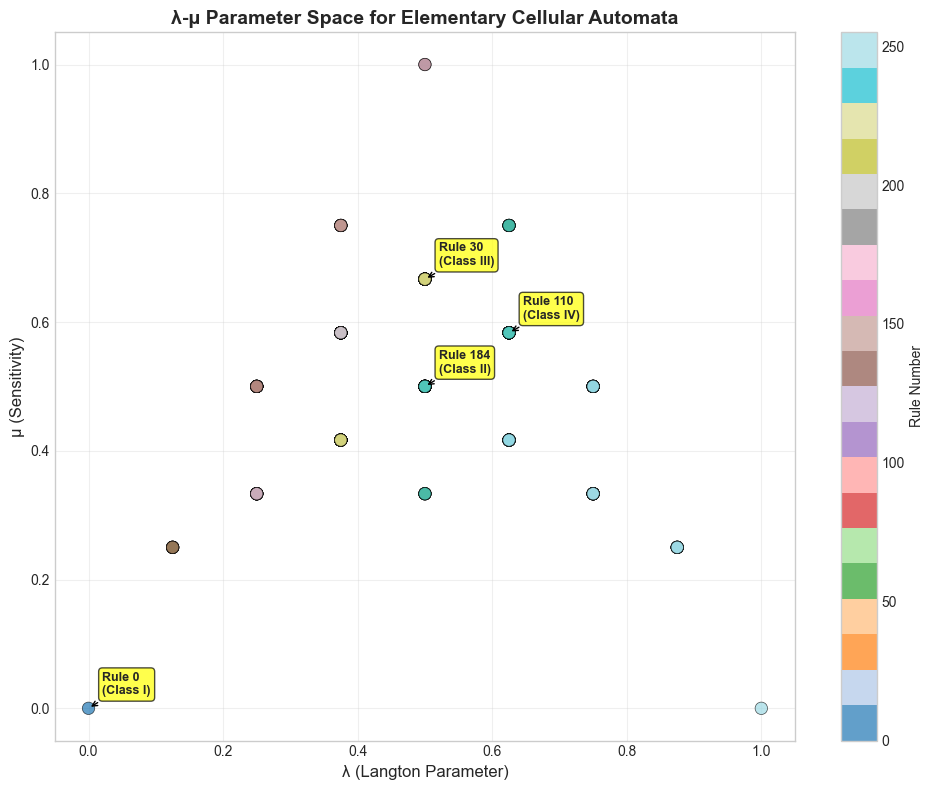

In [7]:
# Visualize λ-μ parameter space
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(features_df['lambda'], features_df['mu'], 
                      c=features_df['rule'], cmap='tab20', 
                      s=80, alpha=0.7, edgecolor='black', linewidth=0.5)

# Highlight specific rules
special_rules = {30: 'Rule 30\n(Class III)', 
                 110: 'Rule 110\n(Class IV)', 
                 184: 'Rule 184\n(Class II)',
                 0: 'Rule 0\n(Class I)'}

for rule, label in special_rules.items():
    row = features_df[features_df['rule'] == rule].iloc[0]
    plt.annotate(label, (row['lambda'], row['mu']), 
                 xytext=(10, 10), textcoords='offset points',
                 fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('λ (Langton Parameter)', fontsize=12)
plt.ylabel('μ (Sensitivity)', fontsize=12)
plt.title('λ-μ Parameter Space for Elementary Cellular Automata', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Rule Number')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Spacetime Evolution Data Generation

In [8]:
# Configuration parameters
N_CELLS = 100          # Number of cells in the lattice
N_STEPS = 300          # Number of evolution time steps
N_SAMPLES = 10         # Number of different initial configurations per rule
DENSITY = 0.5          # Density of 1s in random initial configurations

print("Experimental Configuration:")
print(f"  - Lattice size: {N_CELLS} cells")
print(f"  - Evolution steps: {N_STEPS}")
print(f"  - Samples per rule: {N_SAMPLES}")
print(f"  - Initial density: {DENSITY}")
print(f"  - Total spacetime matrices: {256 * N_SAMPLES} = {256 * N_SAMPLES}")


Experimental Configuration:
  - Lattice size: 100 cells
  - Evolution steps: 300
  - Samples per rule: 10
  - Initial density: 0.5
  - Total spacetime matrices: 2560 = 2560


### 4.1 Generate Spacetime Evolution Data

In [9]:
# Create data directory
os.makedirs('data', exist_ok=True)

# Generate spacetime evolution data
print("Generating spacetime evolution data...")

spacetime_data = {}

for rule in tqdm(range(256), desc="Generating spacetime matrices"):
    spacetime_data[rule] = []
    
    for sample in range(N_SAMPLES):
        # Generate random initial configuration
        initial = (np.random.random(N_CELLS) < DENSITY).astype(np.uint8)
        
        # Evolve the system
        spacetime = evolve_eca(rule, initial, N_STEPS)
        spacetime_data[rule].append(spacetime)

print("Spacetime evolution data generation complete!")

# Save the data
with open('data/spacetime_data.pkl', 'wb') as f:
    pickle.dump(spacetime_data, f)
print("Data saved to data/spacetime_data.pkl")


Generating spacetime evolution data...


Generating spacetime matrices: 100%|██████████| 256/256 [00:21<00:00, 12.00it/s]

Spacetime evolution data generation complete!
Data saved to data/spacetime_data.pkl


### 4.2 Visualize Representative Spacetime Patterns

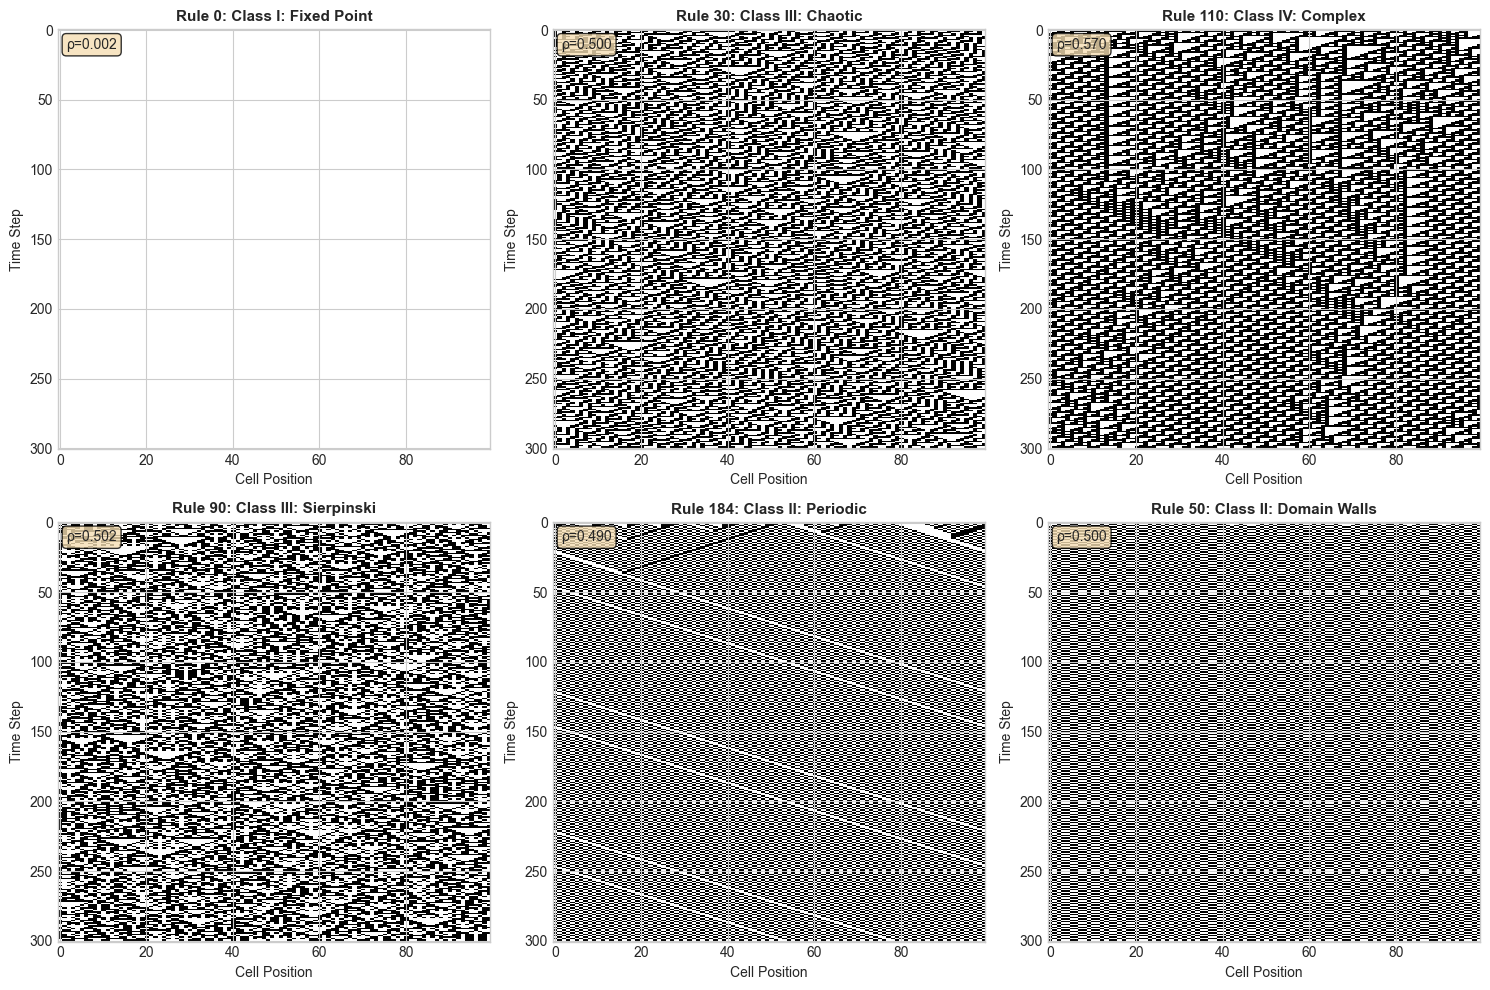

In [10]:
# Display spacetime patterns for different rule classes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

example_rules = [
    (0, "Class I: Fixed Point"),
    (30, "Class III: Chaotic"),
    (110, "Class IV: Complex"),
    (90, "Class III: Sierpinski"),
    (184, "Class II: Periodic"),
    (50, "Class II: Domain Walls")
]

for idx, (rule, description) in enumerate(example_rules):
    ax = axes[idx]
    spacetime = spacetime_data[rule][0]  # First sample
    
    im = ax.imshow(spacetime, cmap='binary', interpolation='nearest', aspect='auto')
    ax.set_title(f'Rule {rule}: {description}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Cell Position')
    ax.set_ylabel('Time Step')
    
    # Add density annotation
    density = np.mean(spacetime)
    ax.text(0.02, 0.98, f'ρ={density:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

## 5. Dynamics-based Feature Extraction

These features capture the temporal evolution characteristics of each rule.

%%[markdown]
### 5.1 Compression Ratio (Kolmogorov Complexity Approximation)

**Theory**: The compression ratio serves as a practical approximation of Kolmogorov complexity.

For a spacetime pattern $S$, the compression ratio is:
$$C(S) = \frac{|compress(S)|}{|S|}$$

where $|S|$ is the size of the original data and $|compress(S)|$ is the compressed size.

**Interpretation**:
- Low compression ratio → High complexity (random/chaotic patterns)
- High compression ratio → Low complexity (regular/periodic patterns)

In [11]:
def compute_compression_ratio(spacetime):
    """
    Compute compression ratio as a proxy for Kolmogorov complexity.
    
    Uses gzip compression with maximum compression level.
    
    Args:
        spacetime (np.array): Binary spacetime matrix
    
    Returns:
        float: Compression ratio (0 < ratio ≤ 1)
    """
    # Convert to bytes
    raw_data = spacetime.tobytes()
    
    # Compress using gzip (maximum compression)
    compressed = gzip.compress(raw_data, compresslevel=9)
    
    # Return ratio
    return len(compressed) / len(raw_data)


# Compute compression features for all rules
print("Computing compression ratio features...")
compression_features = []

for rule in tqdm(range(256), desc="Compression analysis"):
    ratios = []
    for spacetime in spacetime_data[rule]:
        ratio = compute_compression_ratio(spacetime)
        ratios.append(ratio)
    
    # Store mean and standard deviation
    avg_ratio = np.mean(ratios)
    std_ratio = np.std(ratios)
    compression_features.append([rule, avg_ratio, std_ratio])

compression_df = pd.DataFrame(compression_features, 
                             columns=['rule', 'compression_mean', 'compression_std'])

print(f"\nCompression ratio statistics:")
print(f"  Min: {compression_df['compression_mean'].min():.4f}")
print(f"  Max: {compression_df['compression_mean'].max():.4f}")
print(f"  Mean: {compression_df['compression_mean'].mean():.4f}")


Computing compression ratio features...


Compression analysis: 100%|██████████| 256/256 [00:18<00:00, 13.74it/s]


Compression ratio statistics:
  Min: 0.0031
  Max: 0.1638
  Mean: 0.0326


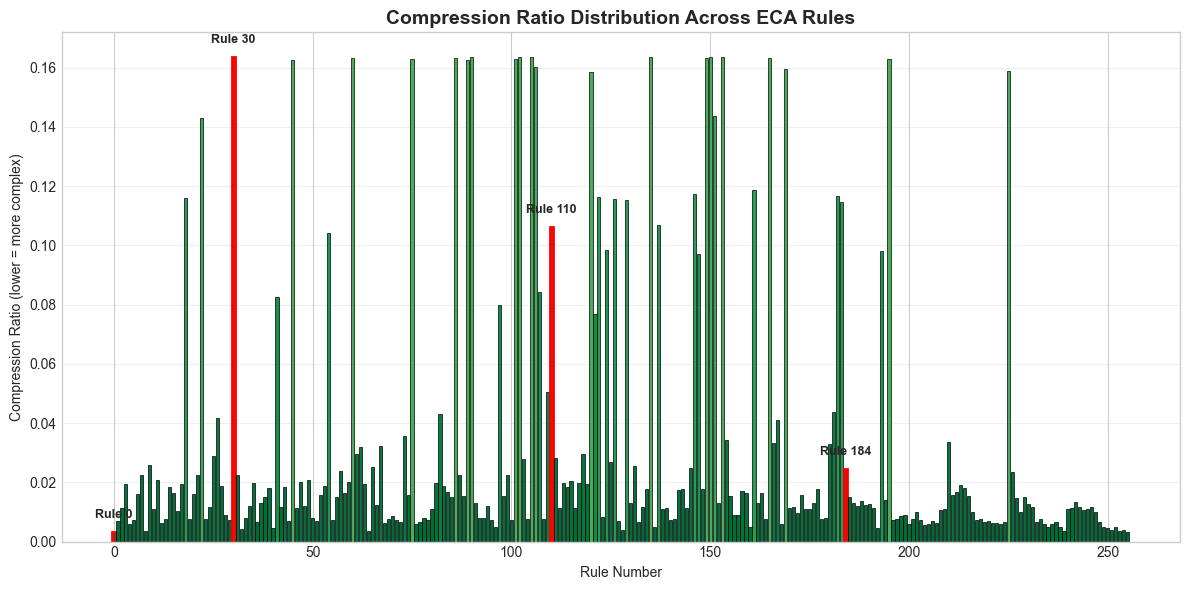

In [31]:
# Visualize compression ratio distribution
plt.figure(figsize=(12, 6))

# Color by compression ratio
colors = plt.cm.RdYlGn_r(compression_df['compression_mean'])

bars = plt.bar(compression_df['rule'], compression_df['compression_mean'], 
                color=colors, edgecolor='black', linewidth=0.5)

# Highlight specific rules
for rule in [30, 110, 184, 0]:
    idx = compression_df[compression_df['rule'] == rule].index[0]
    bars[idx].set_edgecolor('red')
    bars[idx].set_linewidth(2)
    
    # Add annotation
    y_val = compression_df.loc[idx, 'compression_mean']
    plt.annotate(f'Rule {rule}', 
                 (rule, y_val), 
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=9, fontweight='bold')

#plt.axhline(y=0.5, color='blue', linestyle='--', alpha=0.5, label='Midpoint')
plt.title('Compression Ratio Distribution Across ECA Rules', fontsize=14, fontweight='bold')
plt.xlabel('Rule Number')
plt.ylabel('Compression Ratio (lower = more complex)')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Compression: 100%|██████████| 256/256 [00:18<00:00, 13.84it/s]


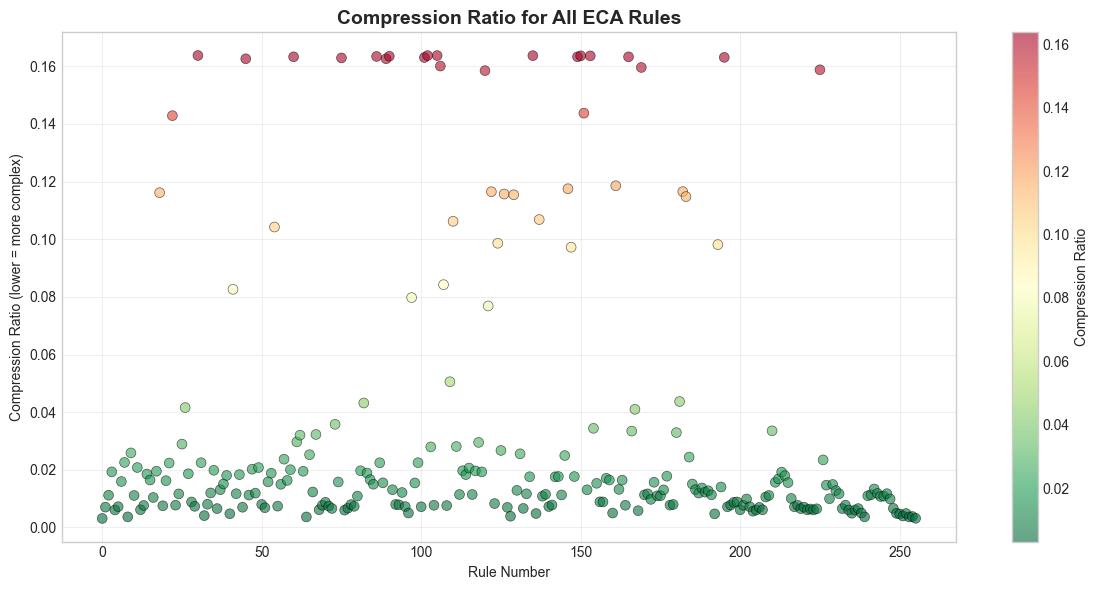

Top 15 Most Complex Rules (lowest compression):
     rule  compression_mean  compression_std
0       0          0.003123         0.000076
255   255          0.003169         0.000045
253   253          0.003638         0.000106
64     64          0.003648         0.000114
239   239          0.003661         0.000074
8       8          0.003671         0.000078
254   254          0.003787         0.000186
128   128          0.003890         0.000225
251   251          0.003967         0.000257
32     32          0.004096         0.000386
250   250          0.004681         0.000362
192   192          0.004718         0.000314
40     40          0.004748         0.000440
252   252          0.004827         0.000351
136   136          0.004837         0.000298


In [32]:
def compute_compression_ratio(spacetime):
    raw_data = spacetime.tobytes()
    compressed = gzip.compress(raw_data, compresslevel=9)
    return len(compressed) / len(raw_data)

compression_features = []

for rule in tqdm(range(256), desc="Compression"):
    ratios = []
    for spacetime in spacetime_data[rule]:
        ratio = compute_compression_ratio(spacetime)
        ratios.append(ratio)
    
    avg_ratio = np.mean(ratios)
    std_ratio = np.std(ratios)
    compression_features.append([rule, avg_ratio, std_ratio])

compression_df = pd.DataFrame(compression_features, 
                               columns=['rule', 'compression_mean', 'compression_std'])

plt.figure(figsize=(12, 6))
plt.scatter(compression_df['rule'], compression_df['compression_mean'], 
            alpha=0.6, s=50, c=compression_df['compression_mean'], 
            cmap='RdYlGn_r', edgecolor='black', linewidth=0.5)
#plt.axhline(y=0.05, color='blue', linestyle='--', alpha=0.5, label='Threshold')
plt.title('Compression Ratio for All ECA Rules', fontsize=14, fontweight='bold')
plt.xlabel('Rule Number')
plt.ylabel('Compression Ratio (lower = more complex)')
plt.colorbar(label='Compression Ratio')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Identify most complex rules
top_complex = compression_df.nsmallest(15, 'compression_mean')
print("Top 15 Most Complex Rules (lowest compression):")
print(top_complex)

### 5.2 Spectral Analysis (Fourier Power Spectrum)

**Theory**: Spectral analysis reveals the frequency components of spacetime patterns.

For a time series $x(t)$, the power spectrum is:
$$P(f) = |X(f)|^2$$

where $X(f)$ is the Fourier transform of $x(t)$.

**Key spectral features**:
1. **Peak frequency**: Dominant oscillation frequency
2. **Spectral entropy**: $H_s = -\sum_f p(f) \log p(f)$, where $p(f) = P(f)/\sum P(f)$
3. **Low-frequency power ratio**: Energy in low frequencies
4. **1/f slope**: Power-law exponent in log-log space

In [13]:
def compute_power_spectrum(spacetime):
    """
    Compute averaged power spectrum across all cells.
    
    Args:
        spacetime (np.array): Binary spacetime matrix
    
    Returns:
        np.array: Averaged power spectrum (positive frequencies only)
    """
    # Apply FFT along time axis for each cell
    fft_result = np.fft.fft(spacetime, axis=0)
    power = np.abs(fft_result)**2
    
    # Average power spectrum across all cells
    avg_power = np.mean(power, axis=1)
    
    # Return positive frequencies only
    half_len = len(avg_power) // 2
    return avg_power[:half_len]


def extract_spectral_features(power_spectrum):
    """
    Extract key features from power spectrum.
    
    Returns:
        list: [peak_freq, peak_power, spectral_entropy, low_freq_power, slope_1f]
    """
    freqs = np.arange(len(power_spectrum))
    
    # 1. Peak frequency (excluding DC component)
    peak_idx = np.argmax(power_spectrum[1:]) + 1
    peak_freq = peak_idx
    peak_power = power_spectrum[peak_idx]
    
    # 2. Spectral entropy
    # Normalize to probability distribution
    probs = power_spectrum / (np.sum(power_spectrum) + 1e-10)
    spectral_entropy = -np.sum(probs * np.log2(probs + 1e-10))
    
    # 3. Low-frequency power ratio (first 10% of spectrum)
    cutoff = max(1, len(power_spectrum) // 10)
    low_freq_power = np.sum(power_spectrum[:cutoff]) / (np.sum(power_spectrum) + 1e-10)
    
    # 4. 1/f slope estimation (fit in log-log space)
    # Use frequencies 1-20 to avoid DC and high-frequency noise
    fit_range = slice(1, min(20, len(power_spectrum)))
    log_freqs = np.log(freqs[fit_range] + 1)
    log_power = np.log(power_spectrum[fit_range] + 1e-10)
    
    if len(log_freqs) > 1:
        slope, _ = np.polyfit(log_freqs, log_power, 1)
    else:
        slope = 0
    
    return [peak_freq, peak_power, spectral_entropy, low_freq_power, slope]

# Compute spectral features for all rules
spectral_features = []

for rule in tqdm(range(256), desc="Spectral analysis"):
    features_list = []
    
    for spacetime in spacetime_data[rule]:
        power_spectrum = compute_power_spectrum(spacetime)
        features = extract_spectral_features(power_spectrum)
        features_list.append(features)
    
    # Average features across samples
    avg_features = np.mean(features_list, axis=0)
    spectral_features.append([rule] + list(avg_features))

spectral_df = pd.DataFrame(spectral_features,
                           columns=['rule', 'peak_freq', 'peak_power', 
                                   'spectral_entropy', 'low_freq_power', 
                                   'slope_1f'])

print("\nSpectral feature summary:")
print(spectral_df.describe())


Spectral analysis: 100%|██████████| 256/256 [00:00<00:00, 378.09it/s]


Spectral feature summary:
             rule   peak_freq    peak_power  spectral_entropy  low_freq_power  \
count  256.000000  256.000000  2.560000e+02      2.560000e+02      256.000000   
mean   127.500000   72.800000  7.882339e+02      2.150628e+00        0.755133   
std     74.045031   52.913474  1.068546e+03      1.831475e+00        0.219256   
min      0.000000    1.000000  4.447815e-29     -1.442662e-10        0.100000   
25%     63.750000    1.000000  2.138658e+01      3.335572e-01        0.653189   
50%    127.500000   73.800000  5.907135e+02      2.078733e+00        0.773952   
75%    191.250000  120.900000  1.015142e+03      3.295651e+00        0.977371   
max    255.000000  149.000000  5.642691e+03      7.228819e+00        1.000000   

           slope_1f  
count  2.560000e+02  
mean   8.451862e-02  
std    4.186423e-01  
min   -1.334838e+00  
25%   -6.880375e-02  
50%   -1.934279e-15  
75%    3.185994e-01  
max    1.173066e+00  


### 5.2.1 Power Spectrum Visualization

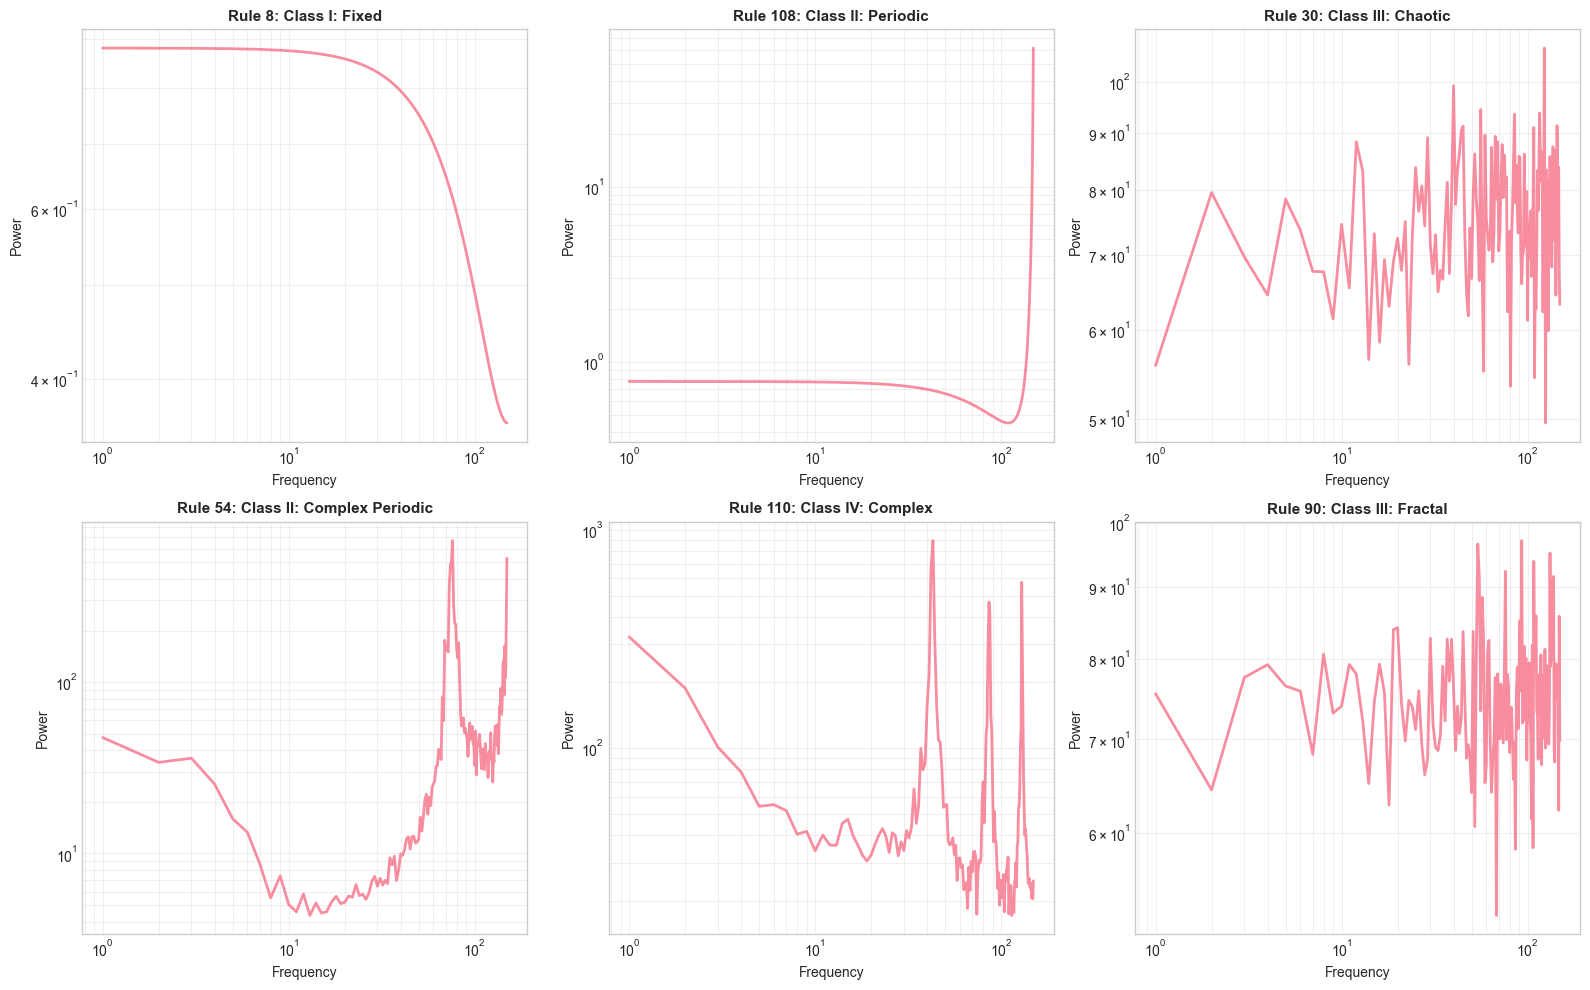

In [14]:
# Visualize power spectra for representative rules
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

example_rules = [
    (8, "Class I: Fixed"),
    (108, "Class II: Periodic"), 
    (30, "Class III: Chaotic"),
    (54, "Class II: Complex Periodic"),
    (110, "Class IV: Complex"),
    (90, "Class III: Fractal")
]

for idx, (rule, description) in enumerate(example_rules):
    ax = axes[idx]
    
    # Compute power spectrum for first sample
    spacetime = spacetime_data[rule][0]
    power_spectrum = compute_power_spectrum(spacetime)
    freqs = np.arange(len(power_spectrum))
    
    # Plot in log-log scale
    ax.loglog(freqs[1:], power_spectrum[1:], alpha=0.8, linewidth=2)
    
    # Add 1/f reference line
    # ref_line = power_spectrum[1] * (freqs[1:] / freqs[1]) ** (-1)
    # ax.loglog(freqs[1:], ref_line, 'k--', alpha=0.3, label='1/f')
    
    ax.set_title(f'Rule {rule}: {description}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


### 5.3 Difference Spreading (Damage Spreading / Lyapunov Exponent)

**Theory**: Difference spreading quantifies sensitivity to initial conditions.

Starting with two configurations differing by a single bit:
$$H(t) = ||\mathbf{x}_1(t) - \mathbf{x}_2(t)||_1$$

The Hamming distance $H(t)$ evolution reveals:
- **Exponential growth**: Chaotic behavior (positive Lyapunov exponent)
- **Linear growth**: Edge of chaos
- **Bounded growth**: Ordered behavior

**Key metrics**:
1. Initial spreading rate: $\frac{dH}{dt}|_{t=0}$
2. Maximum Hamming distance reached
3. Saturation time
4. Average spreading rate

In [15]:
def compute_difference_spreading(rule_number, initial_config, steps):
    """
    Compute Hamming distance evolution between original and perturbed configurations.
    
    Args:
        rule_number (int): ECA rule number
        initial_config (np.array): Initial configuration
        steps (int): Number of evolution steps
    
    Returns:
        np.array: Hamming distance time series
    """
    # Create two initial configurations
    config1 = initial_config.copy()
    config2 = initial_config.copy()
    
    # Introduce single-bit perturbation at center
    config2[len(config2) // 2] ^= 1
    
    hamming_distances = []
    
    # Evolve both configurations and track Hamming distance
    for t in range(steps):
        # Evolve one step
        config1 = evolve_eca(rule_number, config1, 1)[-1]
        config2 = evolve_eca(rule_number, config2, 1)[-1]
        
        # Compute Hamming distance
        H = np.sum(config1 != config2)
        hamming_distances.append(H)
    
    return np.array(hamming_distances)


def extract_spreading_features(hamming_distances):
    """
    Extract features from Hamming distance time series.
    
    Returns:
        list: [initial_slope, max_hamming, saturation_time, spreading_rate]
    """
    # 1. Initial slope (linear fit to first 20 steps)
    initial_steps = min(20, len(hamming_distances))
    t = np.arange(initial_steps)
    
    if initial_steps > 1:
        slope, _ = np.polyfit(t, hamming_distances[:initial_steps], 1)
        slope = max(0, slope)  # Ensure non-negative
    else:
        slope = 0
    
    # 2. Maximum Hamming distance
    max_H = np.max(hamming_distances)
    
    # 3. Saturation time (time to reach 95% of maximum)
    threshold = 0.95 * max_H if max_H > 0 else 0
    saturation_indices = np.where(hamming_distances >= threshold)[0]
    saturation_time = saturation_indices[0] if len(saturation_indices) > 0 else len(hamming_distances)
    
    # 4. Average spreading rate
    spreading_rate = max_H / len(hamming_distances) if len(hamming_distances) > 0 else 0
    
    return [slope, max_H, saturation_time, spreading_rate]

In [16]:
# Compute spreading features for all rules
spreading_features = []

for rule in tqdm(range(256), desc="Spreading analysis"):
    features_list = []
    
    for _ in range(N_SAMPLES):
        # Generate random initial configuration
        initial = (np.random.random(N_CELLS) < DENSITY).astype(np.uint8)
        
        # Compute Hamming distance evolution
        hamming = compute_difference_spreading(rule, initial, 500)
        
        # Extract features
        features = extract_spreading_features(hamming)
        features_list.append(features)
    
    # Average features across samples
    avg_features = np.mean(features_list, axis=0)
    spreading_features.append([rule] + list(avg_features))

spreading_df = pd.DataFrame(spreading_features,
                           columns=['rule', 'initial_slope', 'max_hamming',
                                   'saturation_time', 'spreading_rate'])


Spreading analysis: 100%|██████████| 256/256 [01:09<00:00,  3.67it/s]


### 5.3.1 Damage Spreading Visualization

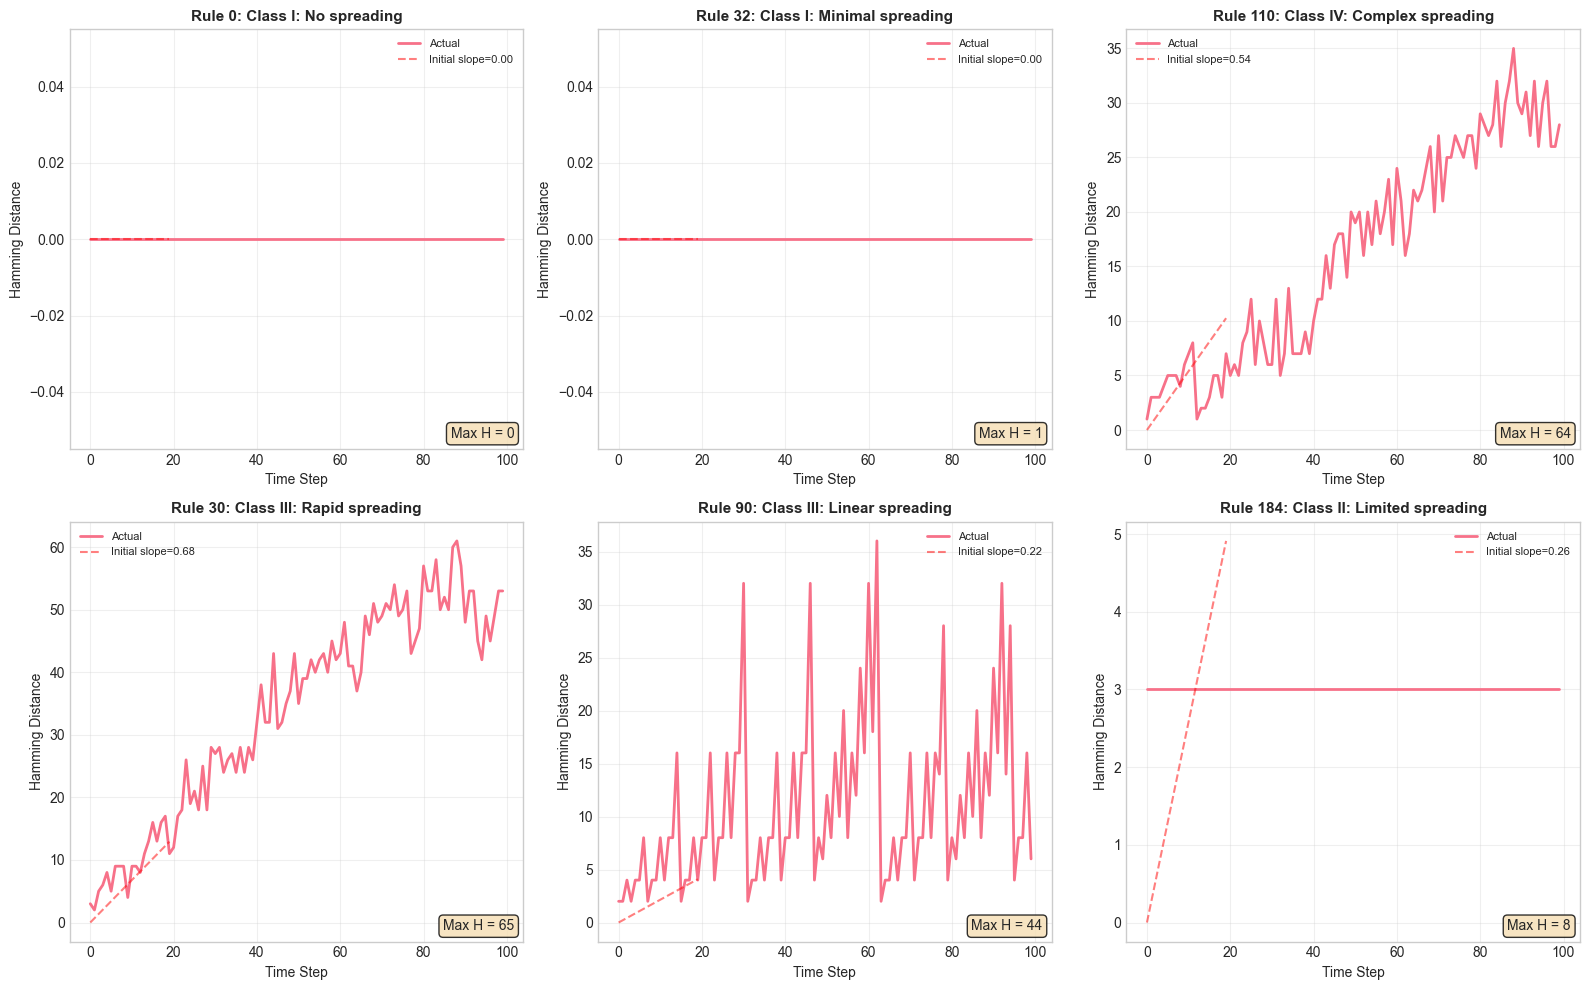

In [17]:
# Visualize damage spreading for different rule classes
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

example_rules = [
    (0, "Class I: No spreading"),
    (32, "Class I: Minimal spreading"),
    (110, "Class IV: Complex spreading"),
    (30, "Class III: Rapid spreading"),
    (90, "Class III: Linear spreading"),
    (184, "Class II: Limited spreading")
]

for idx, (rule, description) in enumerate(example_rules):
    ax = axes[idx]
    
    # Generate sample spreading curve
    initial = (np.random.random(N_CELLS) < 0.5).astype(np.uint8)
    hamming = compute_difference_spreading(rule, initial, 100)
    
    # Get feature values
    rule_features = spreading_df[spreading_df['rule'] == rule].iloc[0]
    
    # Plot
    ax.plot(hamming, linewidth=2, label='Actual')
    
    # Add initial slope line
    t = np.arange(20)
    slope_line = rule_features['initial_slope'] * t
    ax.plot(t, slope_line, 'r--', alpha=0.5, label=f'Initial slope={rule_features["initial_slope"]:.2f}')
    
    ax.set_title(f'Rule {rule}: {description}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Hamming Distance')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    
    # Add annotation
    ax.text(0.98, 0.02, f'Max H = {rule_features["max_hamming"]:.0f}', 
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

### 5.4 Rényi Entropy

**Theory**: Rényi entropy generalizes Shannon entropy and captures different aspects of pattern complexity.

For a probability distribution $\mathbf{p}$, the Rényi entropy of order $\alpha$ is:

$$S_\alpha = \frac{1}{1-\alpha} \log \sum_i p_i^\alpha$$

Special cases:
- $S_0$: Logarithm of support size (number of unique patterns)
- $S_1$: Shannon entropy (limit as $\alpha \to 1$)
- $S_\infty$: Min-entropy (related to most probable pattern)

We compute entropy over block patterns of size 3 to capture local structure.

In [18]:
def compute_renyi_entropy(spacetime, alpha=1, block_size=3):
    """
    Compute Rényi entropy over block patterns.
    
    Args:
        spacetime (np.array): Binary spacetime matrix
        alpha (float): Rényi parameter (0, 1, or other)
        block_size (int): Size of neighborhood blocks
    
    Returns:
        float: Rényi entropy
    """
    # Extract all overlapping blocks
    neighborhoods = []
    
    for t in range(len(spacetime)):
        for i in range(len(spacetime[0])):
            # Extract block with periodic boundary
            neighborhood = 0
            for j in range(block_size):
                idx = (i + j) % len(spacetime[0])
                neighborhood = (neighborhood << 1) | spacetime[t, idx]
            neighborhoods.append(neighborhood)
    
    # Compute probability distribution
    counter = Counter(neighborhoods)
    total = len(neighborhoods)
    probs = np.array([count / total for count in counter.values()])
    
    # Compute Rényi entropy
    if alpha == 1:  # Shannon entropy (special case)
        entropy = -np.sum(probs * np.log2(probs + 1e-10))
    elif alpha == 0:  # Max entropy (log of support)
        entropy = np.log2(len(counter))
    else:
        sum_p_alpha = np.sum(probs ** alpha)
        entropy = np.log2(sum_p_alpha + 1e-10) / (1 - alpha)
    
    return entropy


def compute_entropy_variance(spacetime, window_size=50):
    """
    Compute variance of entropy over time windows.
    
    High variance indicates Class IV behavior (alternating between
    ordered and disordered phases).
    
    Args:
        spacetime (np.array): Binary spacetime matrix
        window_size (int): Size of time windows
    
    Returns:
        float: Variance of windowed entropies
    """
    entropies = []
    
    for t in range(0, len(spacetime) - window_size, window_size):
        window = spacetime[t:t+window_size]
        entropy = compute_renyi_entropy(window, alpha=1)
        entropies.append(entropy)
    
    return np.var(entropies) if len(entropies) > 1 else 0

In [19]:
# Compute entropy features for all rules
print("Computing Rényi entropy features...")
entropy_features = []

for rule in tqdm(range(256), desc="Entropy analysis"):
    s0_list, s1_list, var_list = [], [], []
    
    for spacetime in spacetime_data[rule]:
        # Compute different entropy measures
        s0 = compute_renyi_entropy(spacetime, alpha=0)  # Pattern diversity
        s1 = compute_renyi_entropy(spacetime, alpha=1)  # Shannon entropy
        var = compute_entropy_variance(spacetime)       # Temporal variance
        
        s0_list.append(s0)
        s1_list.append(s1)
        var_list.append(var)
    
    # Average across samples
    entropy_features.append([rule, np.mean(s0_list), np.mean(s1_list), np.mean(var_list)])

entropy_df = pd.DataFrame(entropy_features,
                         columns=['rule', 'S0', 'S1', 'entropy_variance'])

print("\nEntropy statistics:")
print(f"  S0 range: [{entropy_df['S0'].min():.3f}, {entropy_df['S0'].max():.3f}]")
print(f"  S1 range: [{entropy_df['S1'].min():.3f}, {entropy_df['S1'].max():.3f}]")
print(f"  Variance range: [{entropy_df['entropy_variance'].min():.6f}, {entropy_df['entropy_variance'].max():.6f}]")

Computing Rényi entropy features...


Entropy analysis: 100%|██████████| 256/256 [01:50<00:00,  2.31it/s]


Entropy statistics:
  S0 range: [2.981, 3.000]
  S1 range: [0.035, 3.000]
  Variance range: [0.000000, 0.057031]


## 6. Feature Integration and Analysis      
### 6.1 Combine All Features

In [20]:
# Merge all feature dataframes
all_features = features_df.copy()  # Contains: rule, M0-M3, lambda, mu
all_features = all_features.merge(compression_df, on='rule')
all_features = all_features.merge(spectral_df, on='rule')
all_features = all_features.merge(spreading_df, on='rule')
all_features = all_features.merge(entropy_df, on='rule')

print("All features successfully integrated!")
print(f"\n Feature matrix dimensions: {all_features.shape}")
print(f"Total features: {len(all_features.columns) - 1}")  # Exclude 'rule' column
print("\nFeature categories:")
print("  - Rule-based: M0-M3, lambda, mu")
print("  - Compression: compression_mean, compression_std")
print("  - Spectral: peak_freq, peak_power, spectral_entropy, low_freq_power, slope_1f")
print("  - Spreading: initial_slope, max_hamming, saturation_time, spreading_rate")
print("  - Entropy: S0, S1, entropy_variance")

# Save complete feature matrix
all_features.to_csv('data/eca_features.csv', index=False)
print("Complete feature matrix saved to data/eca_features.csv")

All features successfully integrated!

 Feature matrix dimensions: (256, 21)
Total features: 20

Feature categories:
  - Rule-based: M0-M3, lambda, mu
  - Compression: compression_mean, compression_std
  - Spectral: peak_freq, peak_power, spectral_entropy, low_freq_power, slope_1f
  - Spreading: initial_slope, max_hamming, saturation_time, spreading_rate
  - Entropy: S0, S1, entropy_variance
Complete feature matrix saved to data/eca_features.csv


In [21]:
# Define known Wolfram classifications
wolfram_labels = {
    # Class I: Fixed points
    0: 'I', 8: 'I', 32: 'I', 40: 'I', 128: 'I', 136: 'I', 160: 'I', 168: 'I',
    2: 'I', 4: 'I', 12: 'I', 13: 'I', 24: 'I', 34: 'I', 36: 'I', 44: 'I',
    48: 'I', 64: 'I', 68: 'I', 72: 'I', 76: 'I', 96: 'I', 104: 'I', 112: 'I',
    130: 'I', 132: 'I', 140: 'I', 152: 'I', 162: 'I', 164: 'I', 170: 'I', 172: 'I',
    192: 'I', 194: 'I', 200: 'I', 204: 'I', 224: 'I', 226: 'I', 232: 'I', 234: 'I',
    
    # Class II: Periodic
    1: 'II', 3: 'II', 5: 'II', 6: 'II', 7: 'II', 9: 'II', 10: 'II', 11: 'II',
    14: 'II', 15: 'II', 19: 'II', 23: 'II', 25: 'II', 26: 'II', 27: 'II', 28: 'II',
    29: 'II', 35: 'II', 37: 'II', 38: 'II', 42: 'II', 43: 'II', 46: 'II', 50: 'II',
    51: 'II', 54: 'II', 56: 'II', 57: 'II', 58: 'II', 62: 'II', 73: 'II', 77: 'II',
    78: 'II', 94: 'II', 108: 'II', 114: 'II', 133: 'II', 134: 'II', 138: 'II', 142: 'II',
    156: 'II', 172: 'II', 178: 'II', 184: 'II',
    
    # Class III: Chaotic
    18: 'III', 22: 'III', 30: 'III', 45: 'III', 60: 'III', 75: 'III', 86: 'III',
    89: 'III', 90: 'III', 101: 'III', 102: 'III', 105: 'III', 106: 'III', 
    109: 'III', 120: 'III', 122: 'III', 126: 'III', 129: 'III', 131: 'III',
    135: 'III', 145: 'III', 146: 'III', 149: 'III', 150: 'III', 153: 'III',
    154: 'III', 161: 'III', 165: 'III', 169: 'III', 182: 'III', 183: 'III',
    195: 'III', 210: 'III', 225: 'III',
    
    # Class IV: Complex
    41: 'IV', 54: 'IV', 106: 'IV', 110: 'IV', 124: 'IV', 137: 'IV', 
    147: 'IV', 193: 'IV',
}

In [22]:
# Add classification labels
all_features['wolfram_class'] = all_features['rule'].map(wolfram_labels)
all_features['wolfram_class'] = all_features['wolfram_class'].fillna('Unknown')

# Statistics
print("\n Wolfram Classification Distribution:")
print(all_features['wolfram_class'].value_counts().sort_index())
print(f"\nTotal labeled rules: {sum(all_features['wolfram_class'] != 'Unknown')}")
print(f"Unlabeled rules: {sum(all_features['wolfram_class'] == 'Unknown')}")


 Wolfram Classification Distribution:
wolfram_class
I           39
II          43
III         33
IV           8
Unknown    133
Name: count, dtype: int64

Total labeled rules: 123
Unlabeled rules: 133


### 6.3 Feature Correlation Analysis

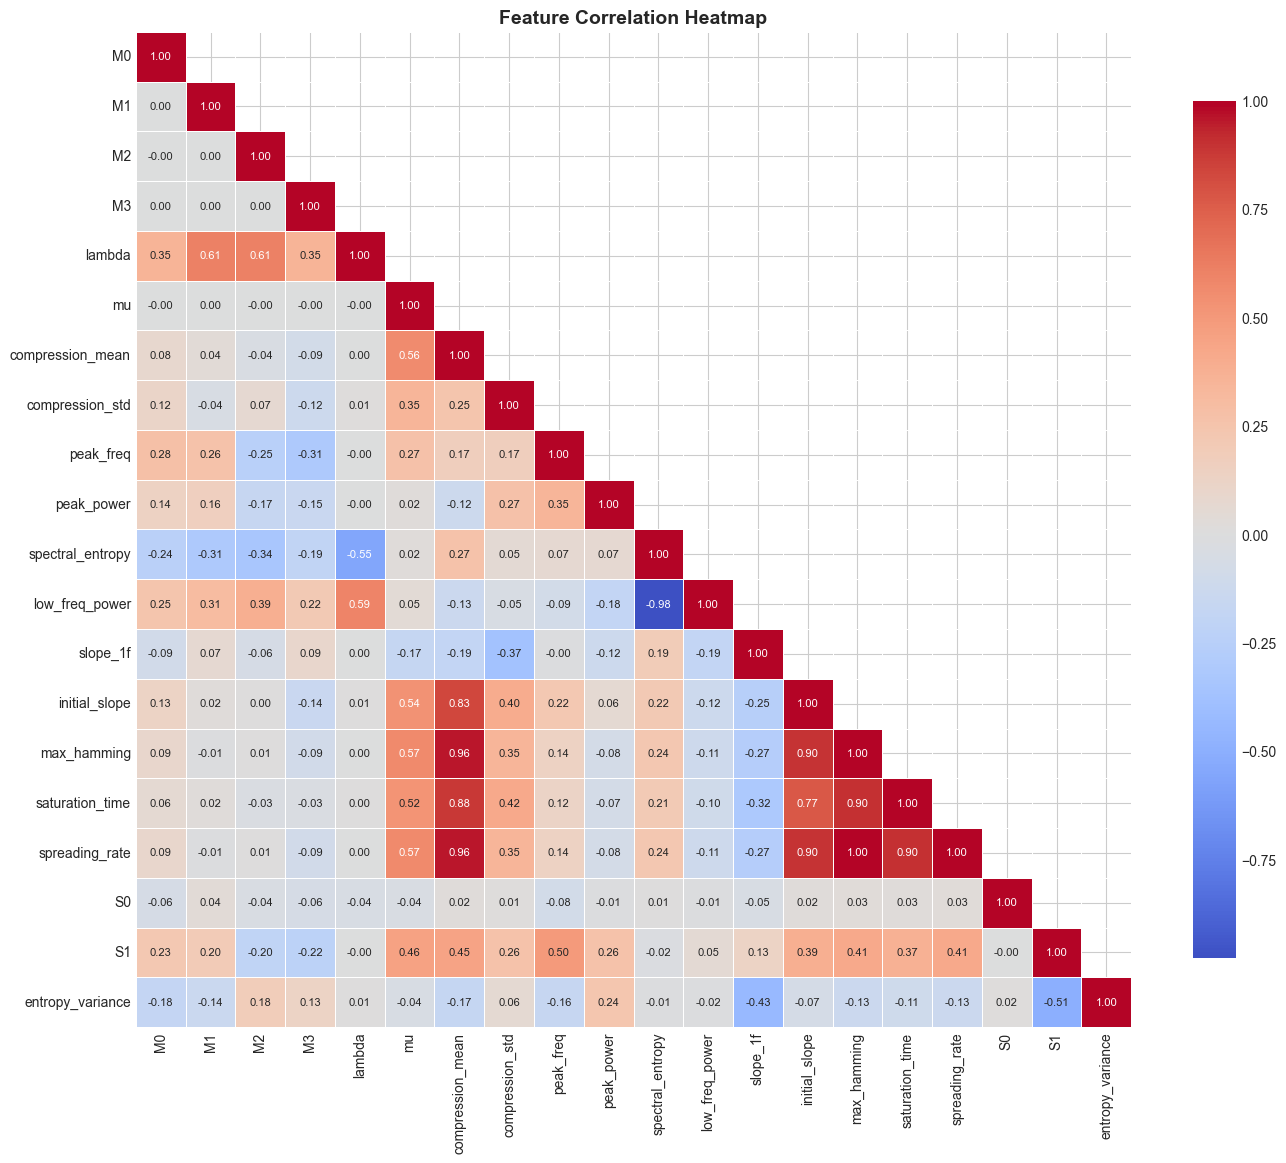

Highly Correlated Feature Pairs (|r| > 0.8):
  max_hamming ↔ spreading_rate: r = 1.000
  spectral_entropy ↔ low_freq_power: r = -0.977
  compression_mean ↔ spreading_rate: r = 0.960
  compression_mean ↔ max_hamming: r = 0.960
  saturation_time ↔ spreading_rate: r = 0.900
  max_hamming ↔ saturation_time: r = 0.900
  initial_slope ↔ spreading_rate: r = 0.898
  initial_slope ↔ max_hamming: r = 0.898
  compression_mean ↔ saturation_time: r = 0.883
  compression_mean ↔ initial_slope: r = 0.833


In [23]:
# Compute and visualize feature correlations
plt.figure(figsize=(14, 12))

# Select numerical feature columns
feature_cols = [col for col in all_features.columns 
                if col not in ['rule', 'wolfram_class']]

# Compute correlation matrix
corr_matrix = all_features[feature_cols].corr()

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix), k=1)  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 8})

plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_val))

print("Highly Correlated Feature Pairs (|r| > 0.8):")
for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")

### 6.4 t-SNE Visualization of Feature Space

Performing t-SNE dimensionality reduction...


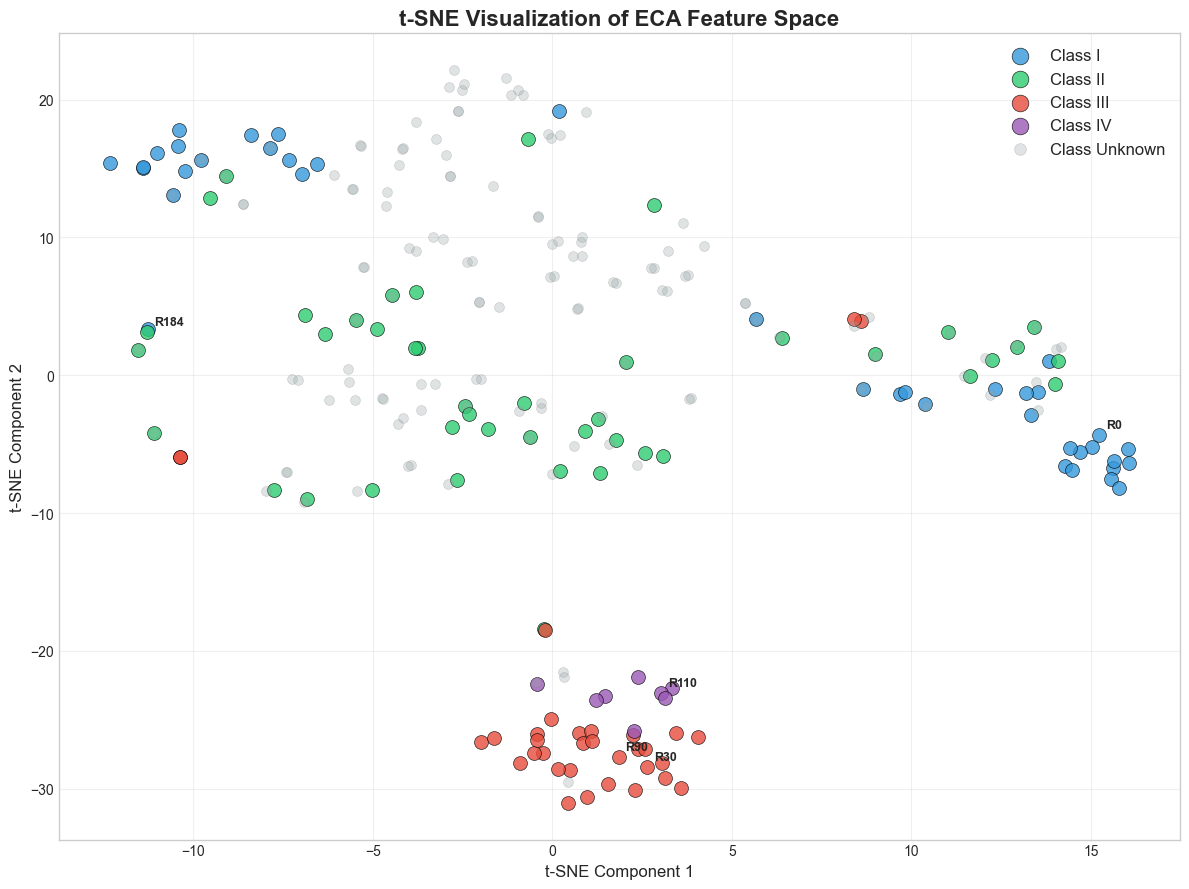

t-SNE visualization complete!


In [24]:
# Prepare data for t-SNE
X = all_features[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

# Perform t-SNE dimensionality reduction
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 9))

# Define colors for each class
colors = {'I': '#3498db', 'II': '#2ecc71', 'III': '#e74c3c', 
          'IV': '#9b59b6', 'Unknown': '#95a5a6'}
labels = all_features['wolfram_class'].values

# Plot each class
for class_label in ['I', 'II', 'III', 'IV', 'Unknown']:
    mask = labels == class_label
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                c=colors[class_label], label=f'Class {class_label}',
                s=100 if class_label != 'Unknown' else 50,
                alpha=0.8 if class_label != 'Unknown' else 0.3,
                edgecolor='black' if class_label != 'Unknown' else 'gray',
                linewidth=0.5)

# Annotate specific interesting rules
interesting_rules = {0: 'R0', 30: 'R30', 110: 'R110', 184: 'R184', 90: 'R90'}
for rule, label in interesting_rules.items():
    idx = all_features[all_features['rule'] == rule].index[0]
    plt.annotate(label, (X_tsne[idx, 0], X_tsne[idx, 1]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, fontweight='bold')

plt.title('t-SNE Visualization of ECA Feature Space', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(fontsize=12, markerscale=1.2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("t-SNE visualization complete!")

### 6.5 Feature Distribution Analysis by Class

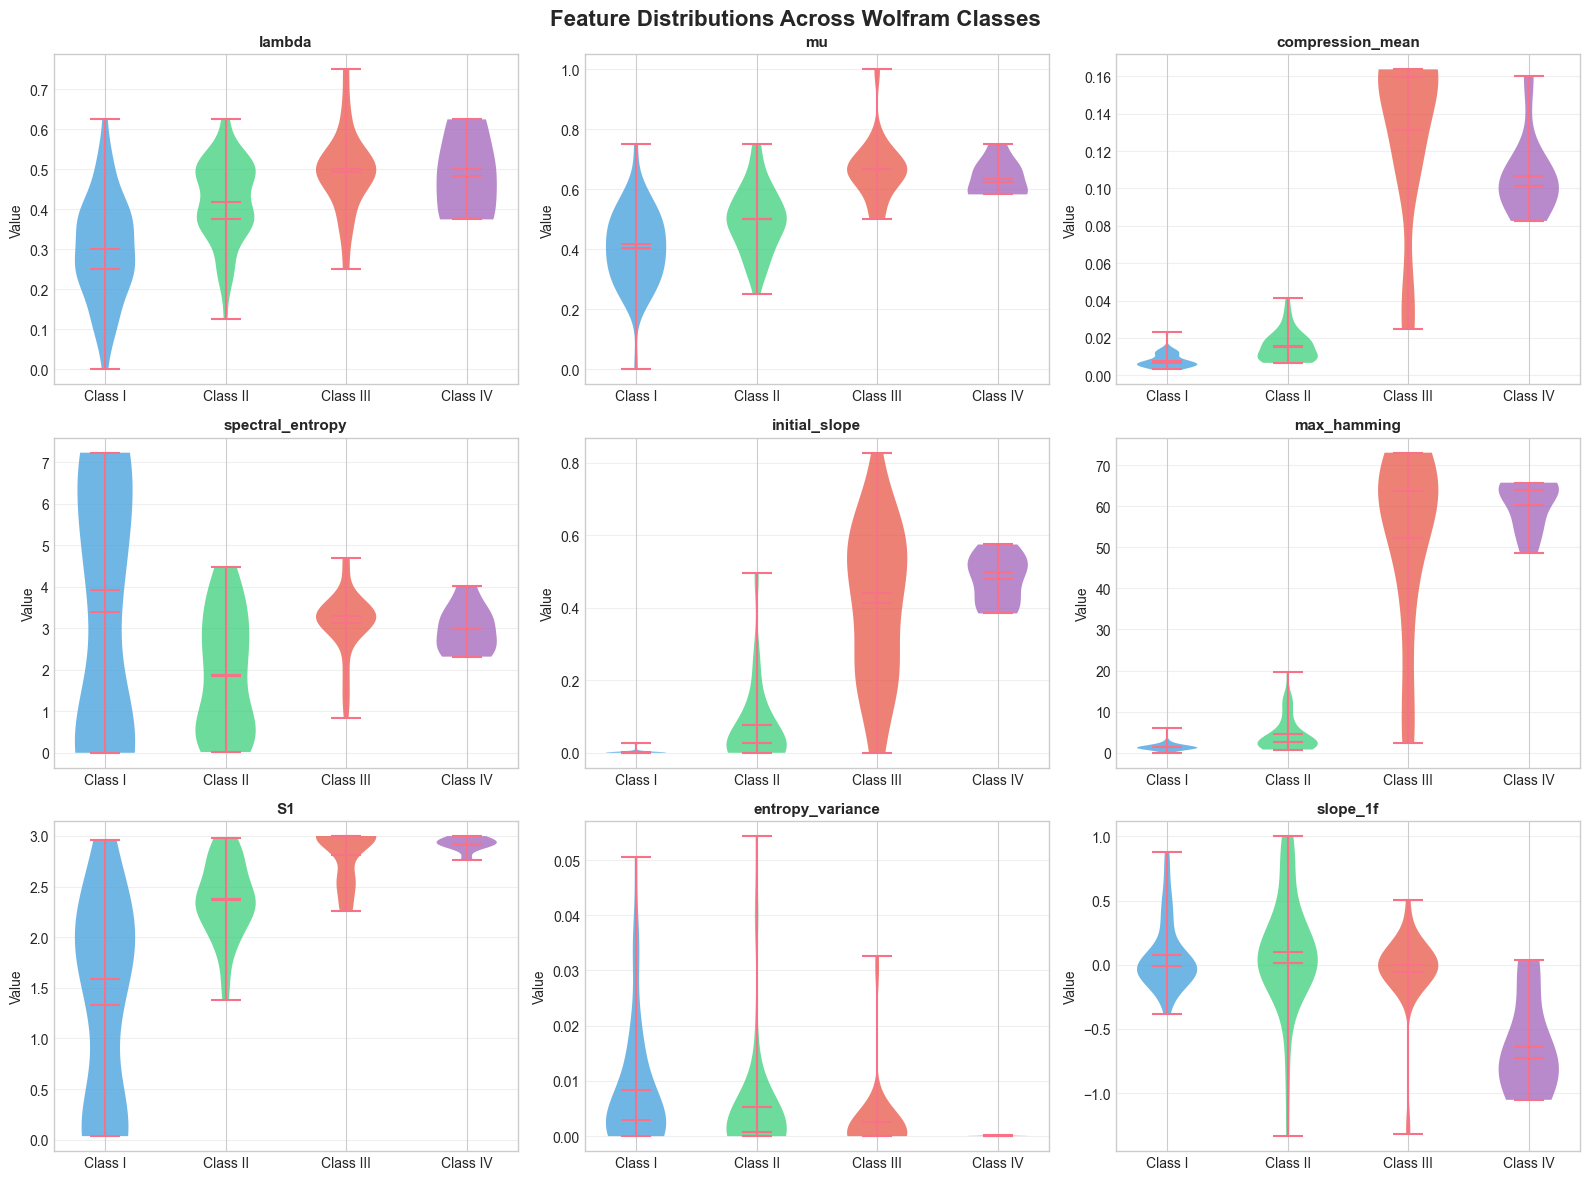

In [25]:
# Analyze feature distributions across Wolfram classes
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

# Select key discriminative features
key_features = ['lambda', 'mu', 'compression_mean', 'spectral_entropy', 
                'initial_slope', 'max_hamming', 'S1', 'entropy_variance', 'slope_1f']

# Filter to labeled data only
labeled_data = all_features[all_features['wolfram_class'] != 'Unknown']

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Create violin plot
    data_by_class = []
    labels = []
    for class_label in ['I', 'II', 'III', 'IV']:
        class_data = labeled_data[labeled_data['wolfram_class'] == class_label][feature].values
        if len(class_data) > 0:
            data_by_class.append(class_data)
            labels.append(f'Class {class_label}')
    
    parts = ax.violinplot(data_by_class, positions=range(len(labels)),
                          showmeans=True, showmedians=True)
    
    # Customize violin plot colors
    for pc, color in zip(parts['bodies'], ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(alpha=0.3, axis='y')

plt.suptitle('Feature Distributions Across Wolfram Classes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Summary and Next Steps

In [26]:
print("\n SUMMARY STATISTICS:")
print(f"  - Total ECA rules analyzed: 256")
print(f"  - Features extracted per rule: {len(feature_cols)}")
print(f"  - Total feature dimensions: {all_features.shape}")
print(f"  - Rules with Wolfram labels: {sum(all_features['wolfram_class'] != 'Unknown')}")

print("\n OUTPUT FILES:")
print("  - data/spacetime_data.pkl: Complete spacetime evolution data")
print("  - data/eca_features.csv: Comprehensive feature matrix")

print("\n KEY FINDINGS:")

# Feature importance based on class separation
from scipy.stats import f_oneway

print("\n1. Most Discriminative Features (ANOVA F-scores):")
f_scores = []
for feature in feature_cols:
    classes = []
    for class_label in ['I', 'II', 'III', 'IV']:
        class_data = labeled_data[labeled_data['wolfram_class'] == class_label][feature].values
        if len(class_data) > 0:
            classes.append(class_data)
    
    if len(classes) > 1:
        f_stat, p_val = f_oneway(*classes)
        f_scores.append((feature, f_stat, p_val))

f_scores.sort(key=lambda x: x[1], reverse=True)
for i, (feat, f_stat, p_val) in enumerate(f_scores[:5]):
    print(f"   {i+1}. {feat}: F={f_stat:.2f}, p={p_val:.2e}")

print("\n 2. Feature Extraction Methods Implemented:")
print("   Mean-field parameters (M0-M3, λ)")
print("   μ-sensitivity (Boolean derivative)")
print("   Compression ratio (Kolmogorov complexity)")
print("   Spectral analysis (Fourier features)")
print("   Difference spreading (Lyapunov-like)")
print("   Rényi entropy (pattern complexity)")

print("\n NEXT STEPS FOR GNN IMPLEMENTATION:")
print("\n 1. Graph Construction Strategies:")
print("   Option A: Rule-Space Graph")
print("     - Nodes: 256 ECA rules")
print("     - Edges: Based on feature similarity or rule relationships")
print("     - Features: Our extracted 19-dimensional vectors")
print("   \n   Option B: Spacetime Evolution Graph")
print("     - Nodes: Cells at each time step")
print("     - Edges: Neighborhood dependencies")
print("     - Features: Local patterns and dynamics")

print("\n 2. GNN Architecture Considerations:")
print("   - Graph Convolutional Networks (GCN)")
print("   - Graph Attention Networks (GAT)")
print("   - GraphSAGE for inductive learning")
print("   - Temporal Graph Networks for dynamic graphs")

print("\n 3. Evaluation Strategy:")
print("   - Cross-validation on labeled rules")
print("   - Transfer learning to unlabeled rules")
print("   - Comparison with traditional ML baselines")
print("   - Interpretability analysis of learned representations")


 SUMMARY STATISTICS:
  - Total ECA rules analyzed: 256
  - Features extracted per rule: 20
  - Total feature dimensions: (256, 22)
  - Rules with Wolfram labels: 123

 OUTPUT FILES:
  - data/spacetime_data.pkl: Complete spacetime evolution data
  - data/eca_features.csv: Comprehensive feature matrix

 KEY FINDINGS:

1. Most Discriminative Features (ANOVA F-scores):
   1. compression_mean: F=190.46, p=2.96e-45
   2. max_hamming: F=173.99, p=2.43e-43
   3. spreading_rate: F=173.99, p=2.43e-43
   4. saturation_time: F=133.72, p=5.91e-38
   5. initial_slope: F=80.47, p=1.67e-28

 2. Feature Extraction Methods Implemented:
   Mean-field parameters (M0-M3, λ)
   μ-sensitivity (Boolean derivative)
   Compression ratio (Kolmogorov complexity)
   Spectral analysis (Fourier features)
   Difference spreading (Lyapunov-like)
   Rényi entropy (pattern complexity)

 NEXT STEPS FOR GNN IMPLEMENTATION:

 1. Graph Construction Strategies:
   Option A: Rule-Space Graph
     - Nodes: 256 ECA rules
     